Active Learning

In [1]:
import numpy as np
from sklearn.datasets import fetch_lfw_people

In [2]:
lfw_people = fetch_lfw_people(min_faces_per_person=200, resize=.8)

In [3]:
n_samples, h, w = lfw_people.images.shape

In [4]:
X = lfw_people.data
n_features = X.shape[1]

In [5]:
# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

In [6]:
n_classes

2

In [7]:
import matplotlib.pyplot as plt

def plot_gallery(image, title, h, w):
    """Helper function to plot a gallery of portraits"""
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    plt.imshow(image.reshape((h, w)), cmap=plt.cm.gray)
    plt.title(title, size=12)
    plt.xticks(())
    plt.yticks(())

In [8]:
#plot_gallery(X, target_names[y], h, w)

In [9]:
from sklearn.decomposition import PCA

In [10]:
pca_all =  PCA(n_components=2).fit(X)

In [11]:
pca_all.components_

array([[-0.00481912, -0.00472381, -0.00460064, ..., -0.00011737,
         0.00025797,  0.00069948],
       [ 0.01076928,  0.01052759,  0.0100046 , ..., -0.01907588,
        -0.0185576 , -0.01754498]], dtype=float32)

In [12]:
pca = pca_all.transform(X)

In [13]:
import pandas as pd

In [14]:
pca_df = pd.DataFrame(pca)
pca_df['y'] = [target_names[i] for i in y ]

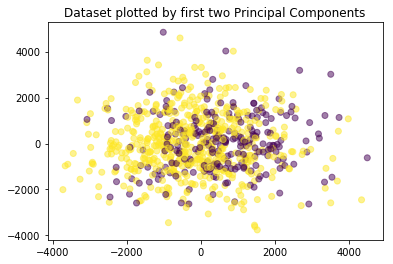

In [15]:
plt.scatter([x[0] for x in pca], [x[1] for x in pca], marker='o', c=y, alpha=.5)
plt.title('Dataset plotted by first two Principal Components')
plt.show()

Test train split

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
# split into a training and testing set
X_train, X_test, y_train, y_test, indices_train,indices_test = \
train_test_split(X, y, np.arange(X.shape[0]), test_size=0.5, random_state=42)

In [18]:
y_split_by_train_test = np.concatenate((y_train, [2 for i in y_test]))

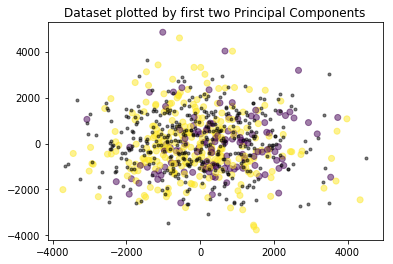

In [19]:
plt.scatter([x[0] for x in pca[indices_train]], [x[1] for x in pca[indices_train]],
            marker='o',
            c=y_train, alpha=.5)
plt.scatter([x[0] for x in pca[indices_test]], [x[1] for x in pca[indices_test]],
            marker='.', c='black', alpha=.5)
plt.title('Dataset plotted by first two Principal Components')
plt.show()

In [20]:
X.shape

(766, 7500)

Performance of random sampling for active learning

In [21]:
from sklearn.linear_model import  LogisticRegression

In [22]:
perc_iterations = np.arange(.05, .6, .05)

In [23]:
perc_iterations

array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55])

In [24]:
perc_iterations = np.arange(.05, .5, .05)
n_iteration = [int(f) for f in  perc_iterations * X.shape[0]]

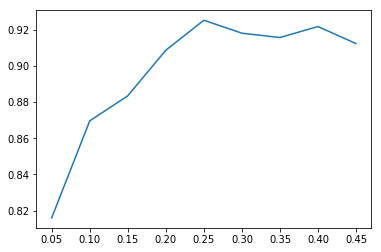

In [25]:
score_random_sampling = []
for i in n_iteration:
    X_train = X[:i]
    y_train = y[:i]
    lr = LogisticRegression(random_state=633).fit(X_train, y_train)
    score_random_sampling.append(lr.score(X[i:], y[i:]) )

%matplotlib inline
plt.plot(perc_iterations, score_random_sampling)

Performance of Uncertainty Labeling

In [26]:
initial_batch = range(n_iteration[0])
index_labeled = np.zeros(len(X), np.bool)
index_labeled[initial_batch] = 1

In [28]:
# Uncertainty sampling
score_uncertainty_sampling = []
N_ROUNDS = 100

for i in range(N_ROUNDS):
    # train and scoreq
    X_train_us = X[index_labeled]
    y_train_us = y[index_labeled]
    lr = LogisticRegression(random_state=633).fit(X_train_us, y_train_us)
    score_uncertainty_sampling.append(lr.score(X[~index_labeled], y[~index_labeled]))
    
    # In unlabelled group, find most uncertain prediction:
    fitted, fitted_index = lr.predict_proba(X[~index_labeled]), np.arange(len(X))[~index_labeled]
    most_uncertain_index_in_test = np.argmin(abs(.5 - fitted[:,1]))
    most_uncertain_index_in_global = fitted_index[most_uncertain_index_in_test]
    # add the most uncertain point to the dataset
    index_labeled[most_uncertain_index_in_global] = 1

In [29]:
assert score_random_sampling[0] == score_uncertainty_sampling[0]

In [30]:
# Translate N points labeled in % points labeled
perc_iterations_us = np.arange(n_iteration[0], n_iteration[0]+N_ROUNDS, 1) * 1. / len(X) 

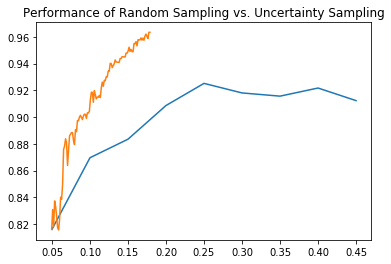

In [32]:
%matplotlib inline
plt.plot(perc_iterations, score_random_sampling)
plt.plot(perc_iterations_us, score_uncertainty_sampling)
plt.title('Performance of Random Sampling vs. Uncertainty Sampling')
plt.show()

In [ ]:
import os; os.getcwd